In [1]:
##Testing the working of Lasagna using a VGG CNN Example

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import urllib
import io
import skimage.transform
import gen_adver as adv

import lasagne
from lasagne.layers import InputLayer, DenseLayer, DropoutLayer
from lasagne.layers.conv import Conv2DLayer as ConvLayer
from lasagne.layers.pool import Pool2DLayer as PoolLayer
from lasagne.layers import LocalResponseNormalization2DLayer as NormLayer
from lasagne.utils import floatX

In [3]:
# Filters the image and prepares it for classification

def prep_image(url):
    ext = url.split('.')[-1]
    im = plt.imread(io.BytesIO(urllib.urlopen(url).read()), ext)
    # Resize so smallest dim = 256, preserving aspect ratio
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (256, w*256/h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*256/w, 256), preserve_range=True)

    # Central crop to 224x224
    h, w, _ = im.shape
    im = im[h//2-112:h//2+112, w//2-112:w//2+112]
    rawim = np.copy(im).astype('uint8')
    
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert to BGR
    im = im[::-1, :, :]
    im = im - MEAN_IMAGE
    return rawim, floatX(im[np.newaxis])

In [4]:
# Neural network architecture - VGG CNN

net = {}
net['input'] = InputLayer((None, 3, 224, 224))
net['conv1'] = ConvLayer(net['input'], num_filters=96, filter_size=7, stride=2)
net['norm1'] = NormLayer(net['conv1'], alpha=0.0001) # caffe has alpha = alpha * pool_size
net['pool1'] = PoolLayer(net['norm1'], pool_size=3, stride=3, ignore_border=False)
net['conv2'] = ConvLayer(net['pool1'], num_filters=256, filter_size=5)
net['pool2'] = PoolLayer(net['conv2'], pool_size=2, stride=2, ignore_border=False)
net['conv3'] = ConvLayer(net['pool2'], num_filters=512, filter_size=3, pad=1)
net['conv4'] = ConvLayer(net['conv3'], num_filters=512, filter_size=3, pad=1)
net['conv5'] = ConvLayer(net['conv4'], num_filters=512, filter_size=3, pad=1)
net['pool5'] = PoolLayer(net['conv5'], pool_size=3, stride=3, ignore_border=False)
net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
net['drop6'] = DropoutLayer(net['fc6'], p=0.5)
net['fc7'] = DenseLayer(net['drop6'], num_units=4096)
net['drop7'] = DropoutLayer(net['fc7'], p=0.5)
net['fc8'] = DenseLayer(net['drop7'], num_units=1000, nonlinearity=lasagne.nonlinearities.softmax)
output_layer = net['fc8']

In [7]:
# Load model parameters and metadata
model = pickle.load(open('/afs/ir/users/m/e/meric/Documents/CS231N/CS231N-FinalProject/datasets/vgg_cnn_s.pkl'))
CLASSES = model['synset words']
MEAN_IMAGE = model['mean image']
lasagne.layers.set_all_param_values(output_layer, model['values'])

IOError: [Errno 2] No such file or directory: '/afs/ir/users/m/e/meric/Documents/CS231N/CS231N-FinalProject/datasets/vggcnn.pkl'

In [8]:
# Validation Set
index = urllib.urlopen('http://www.image-net.org/challenges/LSVRC/2012/ori_urls/indexval.html').read()
image_urls = index.split('<br>')

np.random.seed(23)
np.random.shuffle(image_urls)
image_urls = image_urls[:5]

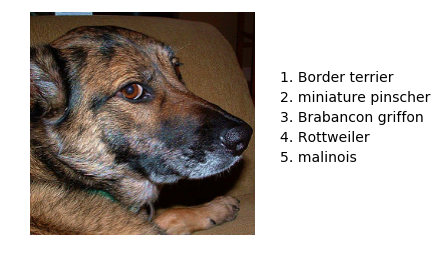

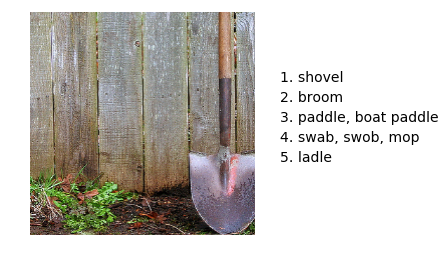

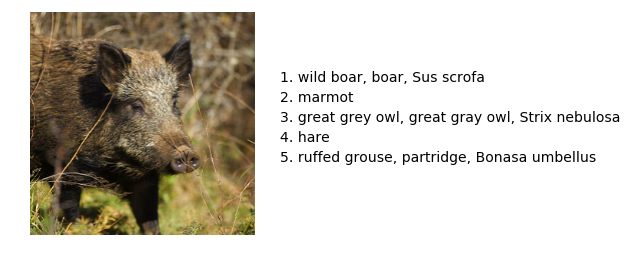

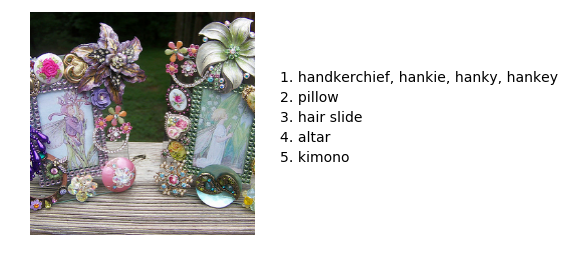

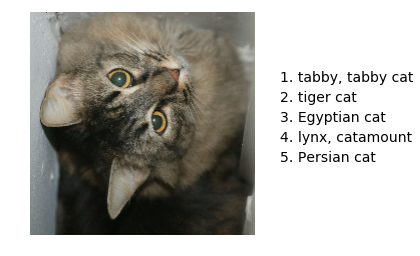

In [9]:
%matplotlib inline

# Process test images and print top 5 labels
count = 0
for url in image_urls:
    try:
        rawim, im = prep_image(url)

        prob = np.array(lasagne.layers.get_output(output_layer, im, deterministic=True).eval())
        top5 = np.argsort(prob[0])[-1:-6:-1]

        plt.figure()
        plt.imshow(rawim.astype('uint8'))
        plt.axis('off')
        for n, label in enumerate(top5):
            plt.text(250, 70 + n * 20, '{}. {}'.format(n+1, CLASSES[label]), fontsize=14)
        plt.show()
        count += 1
    except IOError:
        print('bad url: ' + url)

adver_class = FastGradientSign(num_images = 1,input_dim=(3,224,224), eps=0.0007, 
               loss='softmax' ,dtype=np.float64)
network,grad = adver_class.gradient('vgg19')